# Bond value

Note that these two are usually different: **risk-free rate** (the "rate") and the **coupon rate** of a bond.

## Constant simple rate

##### Question

A 2-year bond has a $4\%$ coupon rate.

The `simple rate` is a constant $3\%$.

What is the current Fair Value of the bond ?

##### Answer

Conventions: notional is 100, coupon payment is semi-annual.

Sum of the PVs of all future cash flows: 

$$\frac{2}{1+\frac{1}{2}\cdot 0.03}+\frac{2}{1+0.03}+\frac{2}{1+\frac{3}{2}\cdot 0.03}+\frac{102}{1+2\cdot 0.03}$$

In [1]:
pv = 2 / (1 + 0.5 * 0.03) + 2 / (1 + 0.03) + 2 / (1 + 1.5 * 0.03) + 102 / (1 + 2 * 0.03)
print(f'{pv:.3f}')

102.052


## Constant zero coupon rate

### What is the practical meaning of the zero coupon rate ?

At the end of each period the coupon is not paid to the bond holder, but it is re-invested together with the notional.

##### Question

A 2-year bond has a $4\%$ coupon rate.

The `zero coupon rate` is a constant $3\%$.

What is the current Fair Value of the bond ?

##### Answer

Conventions: notional is 100, coupon payment is semi-annual.

Sum of the PVs of all future cash flows: 

$$
\frac{2}{1+\frac{0.03}{2}} 
\, + \,
\frac{2}{\left(1+\frac{0.03}{2}\right)^{2}}
\, + \,
\frac{2}{\left(1+\frac{0.03}{2}\right)^{3}}
\, + \,
\frac{102}{\left(1+\frac{0.03}{2}\right)^{4}}
$$



In [2]:
pv = 2 / (1 + 0.5 * 0.03) + 2 / (1 + 0.5 * 0.03) ** 2 + 2 / (1 + 0.5 * 0.03) ** 3 + 102 / (1 + 0.5 * 0.03) ** 4
print(f'{pv:.3f}')

101.927


## Simple rate or zero coupon rate

##### Question

A 2-year bond has a $6\%$ coupon rate.

(a) The `simple rate` is 6M: $5\%$, 1Y: $5.5\%$, 18M: $5.8\%$, 2Y: $6.1\%$.

(b) Apply the same numbers as values of the `zero rate`.

What is the current Fair Value of the bond ?

##### Answer

Sum of the PVs of all future cash flows

(a) with the `simple rate` :
$\,\,\,\,\displaystyle{\frac{3}{1+\frac{1}{2}\cdot 0.05}+\frac{3}{1+0.055}+\frac{3}{1+\frac{3}{2}\cdot 0.058}+\frac{103}{1+2\cdot 0.061}}$

(b) with the `zero coupon rate` :
$\,\,\,\,
\displaystyle{\frac{3}{1+\frac{1}{2}\cdot 0.05}
+
\frac{3}{\left(1+\frac{1}{2}\cdot 0.055\right)^2}
+
\frac{3}{\left(1+\frac{1}{2}\cdot 0.058\right)^3}
+
\frac{103}{\left(1+\frac{1}{2}\cdot 0.061\right)^4}}$



In [3]:
from numbers import Number

NOTIONAL = 100
PRECISION_DIGITS = 3
RATES = {'6m': 0.05, '1y': 0.055, '18m': 0.058, '2y': 0.061}


def two_year_bond_PV(yearly_coupon_percent=None, rate=None, rate_type='zero coupon rate'):
    """
    Calculation of the sum of the PVs of future cash flows received by the holder of the bond
    Discounting can be provided either by the simple rate or the zero coupon rate
    Coupon payment is semi-annual
    """
    assert isinstance(yearly_coupon_percent, Number), 'Please provide a number for "yearly_coupon_percent"'
    assert isinstance(rate, dict), '"rate" should be a dict'
    for t in ['6m', '1y', '18m', '2y']:
        assert t in rate, f'"rate" must provide a value for time={t}'

    coupon_frequency = 2  # twice per year
    coupon = NOTIONAL * yearly_coupon_percent / 100.0 / coupon_frequency

    if rate_type == 'simple rate':
        value = (coupon /              (1 + 0.5 * rate['6m'] ) +
                 coupon /              (1 + 1.0 * rate['1y'] ) +
                 coupon /              (1 + 1.5 * rate['18m']) +
                 (NOTIONAL + coupon) / (1 + 2.0 * rate['2y'] )
                )
    elif rate_type == 'zero coupon rate':
        value = (coupon /              (1 + 0.5 * rate['6m'] ) +
                 coupon /              (1 + 0.5 * rate['1y'] ) ** 2.0 +
                 coupon /              (1 + 0.5 * rate['18m']) ** 3.0 +
                 (NOTIONAL + coupon) / (1 + 0.5 * rate['2y'] ) ** 4.0
                )
    else:
        raise ValueError(f'This rate_type is not available: {rate_type}')

    return value


price = two_year_bond_PV(yearly_coupon_percent=6, rate=RATES, rate_type='simple rate')
print(f'Bond PV using the **simple** rate: {price:.{PRECISION_DIGITS}f}')

price = two_year_bond_PV(yearly_coupon_percent=6, rate=RATES)
print(f'Bond PV using the **zero coupon** rate: {price:.{PRECISION_DIGITS}f}')

Bond PV using the **simple** rate: 100.331
Bond PV using the **zero coupon** rate: 99.859


# Bond yield (also called: Yield to maturity)

The constant zero coupon rate that makes the sum of the PVs of future cash flows equal the current market price. 

Note that a bond yield means applying the `same discount rate` for discounting any future cash flow to the present.

In [4]:
from scipy.optimize import root_scalar

CURRENT_MARKET_VALUE = 98.03
YEARLY_COUPON_PERCENT = 6


def two_year_bond_PV_vs_bond_yield(bond_yield, yearly_coupon_percent=YEARLY_COUPON_PERCENT):
    yield_curve_with_zero_coupon_rate = {'6m': bond_yield, '1y': bond_yield, '18m': bond_yield, '2y': bond_yield}
    return two_year_bond_PV(yearly_coupon_percent=yearly_coupon_percent, rate=yield_curve_with_zero_coupon_rate)


def difference_of_calculated_PV_from_market_value(bond_yield, current_market_value=CURRENT_MARKET_VALUE):
    return two_year_bond_PV_vs_bond_yield(bond_yield) - current_market_value


bond_yield = root_scalar(difference_of_calculated_PV_from_market_value, bracket=[0,1]).root

print(f'Bond yield is {100 * bond_yield:.2f}%')

Bond yield is 7.07%


## Movements of bond price and yield

##### Question

If a bond's price (market value) drops and everything else remains the same, then how does the bond's yield change ?

##### Long Answer (contains detailed steps, precise description)

  1. See the definition. The yield is that particular zero coupon rate that produces the current market value of the bond.
  2. So to obtain the bond's lower market value, the same future cash flows will need to be discounted with a higher discount rate.
  3. In summary, if a bond's price drops and everything else stays the same, then the bond's yield increases.

##### Short Answer (no details, less precise, simple summarized insight)

  4. Yield is the return divided by the price.

##### Conclusion

  In summary, `bond price and bond yield move in opposite directions`.

## Par yield
The `par value` of a bond means the face value of the bond.

The `par yield` of a bond is the yield that makes the calculated PV equal to the par value.

Observe that for a bond currently selling at par, the current par yield is the coupon value.

In [5]:
PAR_VALUE = NOTIONAL


def difference_of_calculated_PV_from_par_value(bond_yield, par_value=PAR_VALUE):
    return two_year_bond_PV_vs_bond_yield(bond_yield) - par_value


par_yield = root_scalar(difference_of_calculated_PV_from_par_value, bracket=[0,1]).root

print(f'The par value is {PAR_VALUE}. The par yield is {100 * par_yield:.2f}%')

The par value is 100. The par yield is 6.00%


## Calculating bond price vs yield, coupon, notional, tenor and coupon frequency

### The coupon is a fixed % of the face value

The coupon is usually a fixed percent of the face value. The price (market value) of the bond can change.

Bond **A** and Bond **B** both have a face value of $\,100\,$ and a yearly coupon of $\,10\,$. Their current market values are $\,S_A=100\,$ and $\,S_B=80\,$.

Your investment in Bond **A** returns $\,10\,\mathit{/}\,100\,=\,10\%\,$ per year, while Bond **B** returns  $\,10\,\mathit{/}\,80\,=\,12.5\%\,$.

In other words, when all other parameters are unchanged `lower bond price means higher bond yield`.

##### Comment

For calculations the face value (notional) is usually set to $\,100\,$. That allows percent values to be expressed as numbers.

<br/>


### Bond price

The bond's notional is $\,N\,$, its duration is $\,T\,$ years (integer), and it pays $\,m\,$ times per year with a yearly coupon rate of $\,c\,$.

Consider a simple case when this ($m$-step compounded) `bond yield` is the same $\,y\,$ for all coupon payment time points.

Note that the coupon payment times are $\,t\,=\,\frac{1}{m},\,\frac{2}{m},\,\dots,\,T-\frac{1}{m},\,T\,$.

The bond price, $\,B\,$, equals the &nbsp; <span style="color:blue;font-weight:bold;">PV of the final notional repayment</span> &nbsp; plus the &nbsp; <span style="color:green;font-weight:bold;">sum of the PVs of the coupons</span>&nbsp; :

$$\displaystyle{
B \left(\,y\,\right) 
\,\, = \,\, 
\color{blue}{ \frac{N}{\left(\,1 + \frac{y}{m}\,\right)^{m\,T}} }
\,\, + \,\,
\color{green}{\frac{c}{m}  \sum_{\,t\,=\,{1\,{\mathit /}\,m}}^{\,T}  \frac{1}{\left(\,1 + \frac{y}{m}\,\right)^{m\,t}} }
}$$

##### With continuous compounding

Recall that the continuously compounded rate, $\,r\,$, is connected to the $\,m\,$- step compounded zero coupon rate, $\,y\,$ :

$$P\left(\,T\,\right) \, = \, e^{\,-\,r\,T} \, = \, \left(\,1 + \frac{y}{m}\,\right)^{\,-\,m\,T}\,,$$

therefore, with `continuous compounding` the bond's price is

$$\displaystyle{
B \left(\,r\,\right) 
\,\, = \,\, 
\color{blue}{ N\,e^{\,-\,r\,T} }
\,\, + \,\,
\color{green}{ \frac{c}{m} \sum_{\,t\,=\,{1\,{\mathit /}\,m}}^{\,T}  e^{\,-\,r\,t} }
}\,.$$

<br/>

##### First and second derivatives

For the numerical calculations the first derivative is

$$\displaystyle{
\color{red}{ \frac{\partial}{\partial\,y}\,B\left(\,y\,\right) } 
\,\, =
\color{blue}{
\,\,-\,\,
\frac{N\,T}{\left(\,1 + \frac{y}{m}\,\right)^{m\,T\,+\,1}}
}
\color{green}{
\,\,\, - \,\,
\frac{c}{m} \, \sum_{\,t\,=\,{1\,{\mathit /}\,m}}^{\,T}  \frac{t}{\left(\,1 + \frac{y}{m}\,\right)^{m\,t\,+\,1}} 
}
\,\, \color{red}{< \,\, 0} }\,\,\,,$$

and the second derivative is

$$\displaystyle{
\color{red}{ \frac{\partial^{\,2}}{\partial\,y^{\,2}}\,B\left(\,y\,\right) } 
\,\, =
\color{blue}{ \,\,
\frac{N\,T \left(\,T + \frac{1}{m}\,\right)}{\left(\,1 + \frac{y}{m}\,\right)^{m\,T\,+\,2}}
}
\color{green}{
\,\,\, + \,\,
\frac{c}{m} \, \sum_{\,t\,=\,{1\,{\mathit /}\,m}}^{\,T} 
                 \frac{t \left(\,t + \frac{1}{m}\,\right)}{\left(\,1 + \frac{y}{m}\,\right)^{m\,t\,+\,2}} 
}
\,\, \color{red}{> \,\, 0} }\,\,\,.$$


### Conclusions

For a simple bond, the bond price vs yield

* `slope is negative`

* `curve is convex` (any straight line segment connecting two points of the function lies above the function)

In [6]:
import numpy as np
from matplotlib import pyplot as plt

ALLOWED_YEARLY_FREQUENCIES_OF_COUPON_PAYMENT = [1, 2, 3, 4, 6, 12]
BOND_FACE_VALUE = 100.0
BOND_DURATION_IN_YEARS = 20.0  # number of years from the start to the maturity of the bond
COUPON_PAYMENT_FREQUENCY = 2
PLOT_MARKERSIZE = 2
BOND_PRICER_USES = ['pv', 'slope', 'duration']


def bond_pricer(yearly_coupon_percent=None, coupon_payment_frequency=None, zero_rates=None, use='pv'):
    """
    Generalized bond pricer
    . yearly_coupon_percent: the % amount of the total coupon paid annually
    . coupon_payment_frequency: how many times per year is there a coupon payment
      -> note that at each payment the coupon paid is notional * 100 * coupon % / frequency
    . zero_rates: the list of zero coupon rates on the coupon payment dates

    Note:
    . The first value in zero_rates is the zero coupon rate for the first coupon payment day.
    . The bond matures at  length(zero_rates) / coupon_payment_frequency  year(s) from its start.

    Available uses:
    . pv:  B(y) = Bond price at start date as a function of the bond's yield
    . slope:  partial B(y) / partial y
    """
    assert coupon_payment_frequency in ALLOWED_YEARLY_FREQUENCIES_OF_COUPON_PAYMENT, \
        f'This coupon payment frequency is not available: {coupon_payment_frequency}'
    assert isinstance(zero_rates, list) and len(zero_rates) and all(isinstance(r, float) for r in zero_rates), \
        '"zero_rates" should be a non-empty list of floats'
    assert use in BOND_PRICER_USES, 'Bond pricer can be used for: ' + ', '.join(BOND_PRICER_USES)
    
    yearly_coupon = BOND_FACE_VALUE * yearly_coupon_percent / 100.0

    # --- calculate bond price ---
    if use == 'pv':
        # discount factor from the date of maturity to the start date
        discount_factor = (1.0 + zero_rates[-1] / coupon_payment_frequency) ** (- 1.0 - len(zero_rates))
        # present value of notional paid at maturity
        bond_pv = BOND_FACE_VALUE * discount_factor
        # adding the PVs of the coupon payments, note that 'enumerate' starts the numbering from 0, not 1
        one_coupon_payment = yearly_coupon / coupon_payment_frequency
        for index_of_coupon_payment_time, zero_rate in enumerate(zero_rates):
            discount_factor = (1.0 + zero_rate / coupon_payment_frequency) ** (- 1.0 - index_of_coupon_payment_time)
            bond_pv += discount_factor * one_coupon_payment

        return bond_pv

    # --- calculate dB / dy ---
    elif use == 'slope':
        # partial derivative of the PV of the final notional payment
        dB_over_dy = ((-1.0) * BOND_FACE_VALUE * BOND_DURATION_IN_YEARS 
                      / (1.0 + zero_rates[-1] / coupon_payment_frequency)
                        ** (coupon_payment_frequency * BOND_DURATION_IN_YEARS + 2))
        # adding partial derivatives of the PVs of coupon payments
        for index_of_coupon_payment_time, zero_rate in enumerate(zero_rates):
            dB_over_dy -= (yearly_coupon / coupon_payment_frequency ** 2
                           * (index_of_coupon_payment_time + 1)
                           / (1.0 + zero_rate / coupon_payment_frequency) ** (2.0 + index_of_coupon_payment_time))
        return dB_over_dy        

    else:
        raise ValueError(f'This "use" value is not available: {use}')

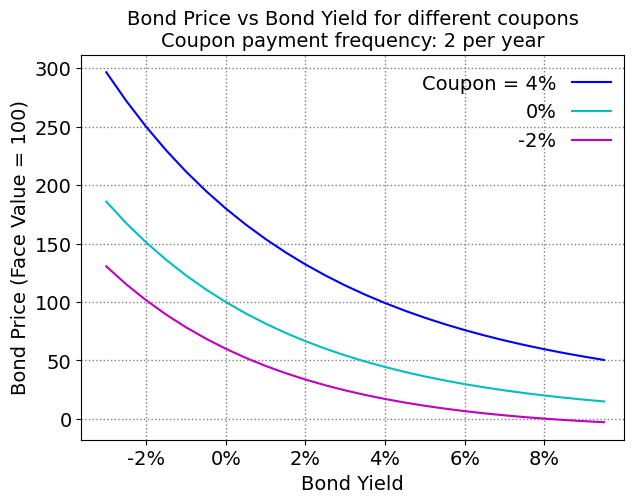

In [7]:
def plot_bond_price_vs_bond_yield():
    """Plot bond price vs bond yield"""

    # --- settings ---
    bond_yields = np.arange(-0.03, 0.10, 0.005)
    fontsize = 14  # font size for the text of the current plot
    coupons_symbols = [(4.0, 'b-', True), (0.0, 'c-', False), (-2.0, 'm-', False)]
    
    # --- calculating the price as a function of the yield and plotting for several coupon percent values ---
    for coupon_percent, symbol, note in coupons_symbols:    
        bond_prices = []
        for bond_yield in bond_yields:
            coupon_payment_frequency = COUPON_PAYMENT_FREQUENCY
            zero_rates = [bond_yield] * int(BOND_DURATION_IN_YEARS * coupon_payment_frequency)
            pv = bond_pricer(yearly_coupon_percent=coupon_percent, zero_rates=zero_rates,
                             coupon_payment_frequency=coupon_payment_frequency, use='pv')
            bond_prices.append(pv)

        # --- plotting ---
        plt.plot(bond_yields, bond_prices, symbol, markersize=PLOT_MARKERSIZE,
                 label=('Coupon = ' if note else '') + f'{coupon_percent:.0f}%')

    plt.grid(color='gray', linestyle=':', linewidth=1)
    plt.title(('Bond Price vs Bond Yield for different coupons\n'
               f'Coupon payment frequency: {COUPON_PAYMENT_FREQUENCY} per year'),
              fontsize=fontsize)
    plt.xlabel('Bond Yield', fontsize=fontsize)
    plt.ylabel('Bond Price (Face Value = 100)', fontsize=fontsize)
    plt.xlim(right=0.1)
    plt.legend(bbox_to_anchor=(.99, .97), loc=1, borderaxespad=0., fontsize=fontsize, markerfirst=False, frameon=False)
    xtick_values = plt.xticks()[0][1:-1]
    plt.xticks(xtick_values, [str(round(100 * value)) + '%' for value in xtick_values], fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    fig = plt.gcf()
    fig.set_size_inches([7, 5])
    plt.show()


plot_bond_price_vs_bond_yield()

# Bond Duration

1. Bond duration is the time to receive the initial payment back.
2. Bond duration is the sensitivity of the bond price to the yield.

## The time to get your money back

Bond duration is the expected time to receive back the initially paid amount.

##### Example: Zero Coupon Bond

Consider a $\,T\,$ year zero coupon bond starting today with face value $\,N\,$ . The PV is below the face value.
<br/>
Alice purchases now this bond bond, and she will receive back her currently paid PV amount of money at the time of maturity.
<br/>
So the duration of the zero coupon bond is its time to maturity.

##### Example: Bond with Coupons

Due to the non-zero coupons, Alice will receive back a non-zero amount of money already before maturity.
<br/>
Thus, the payment-weighted average time of receiving back the initially paid price will be before maturity.

## Sensitivity to a changing yield

Bond duration is also the sensitivity of the bond's price to the changing yield.

### Example with a Zero Coupon Bond

##### Recall the definition of bond yield

A bond's yield is that particular zero coupon rate 
<br/>
that makes the sum of the discounted values of the bond's future cash flows
<br/>
equal to the bond's current market value, also called its PV.

##### Simple example with a Zero Coupon Bond (ZCB)


If the yield changes, then -1 times the `relative rate of change` of the ZCB's PV will be
$\,-\displaystyle{\,\frac{1}{B}\,\frac{\partial\,B\left(\,y\,\right)}{\partial\,y}\,
=\,\frac{\,T\,N\,e^{\,-\,y\,T}}{N\,e^{\,-\,y\,T}}
=\,T}\,$.

### Sensitivity = Modified duration

#### Definition by generalizing the example of the ZCB

For historical reasons, the above described sensitivity is called the `modified duration`:

$\,\displaystyle{D_{\,\text{modified}} = -\,\,\frac{1}{B\left(\,y\,\right)}\,\, \frac{\partial}{\partial\,y}\,B\left(\,y\,\right)}\,$.
  

#### Insert the previously calculated expressions

This is the full formula of the modified duration :

$$
D_{\,\text{modified}} \,\, =
\frac{
\displaystyle{
\color{blue}{ \frac{N\,T}{\left(\,1 +  \frac{y}{m}\,\right)^{m\,T\,+\,1}}  }
}
\,\, + \,\,
\displaystyle{
\color{green}{ \frac{c}{m} \, \sum_{\,t\,=\,{1\,{\mathit /}\,m}}^{\,T}  \frac{t}{\left(\,1 + \frac{y}{m}\,\right)^{m\,t\,+\,1}}}
}
}
{
\displaystyle{
\color{blue}{ \frac{N}{\left(\,1 + \frac{y}{m}\,\right)^{m\,T}} }
}
\,\, + \,\,
\displaystyle{
\color{green}{\frac{c}{m}  \sum_{\,t\,=\,{1\,{\mathit /}\,m}}^{\,T}  \frac{1}{\left(\,1 + \frac{y}{m}\,\right)^{m\,t}} }
}
}
$$

#### Observe the present values of payments

Observe that the present value of the final notional repayment is
$\,\,\,\,
\displaystyle{
\frac{N}{ \left(\,1 +  \frac{y}{m}\,\right)^{m\,T} }
}\,\,,
$

and the PV of the coupon payment at time $\,t\,$ is 
$\,\,\,\,
\displaystyle{
\frac{c}{m}  \, \frac{1}{\left(\,1 + \frac{y}{m}\,\right)^{m\,t} }
}\,\,.
$

Also, note that for a `single` coupon `period` the `discount factor` is $\,\left(\,1 +  \frac{y}{m}\,\right)^{-\,1}\,$ .

#### Summarize the observations

In the above detailed formula for $\,D_{\,\text{modified}}\,$,
<br/>
from both terms of the enumerator
<br/>
move to the front the single-period discount factor to see that

<br/>

$$
D_{\,\text{modified}} \,\, = \,\, 
\text{single-period discount factor} \,\, * \,\,  \text{weighted average of payment times where weights are payment current values}
$$

### Macaulay duration

In short, $\,D_{\,\text{Macaulay}} = \displaystyle{ \left( 1 +  \frac{y}{m} \right) \cdot D_{\,\text{modified}} } $


In more detail,
$\,D_{\,\text{Macaulay}} \,\, = \,\, \text{weighted average of payment times where weights are payment current values}\,.$



### Calculation of sensivity (modified duration)

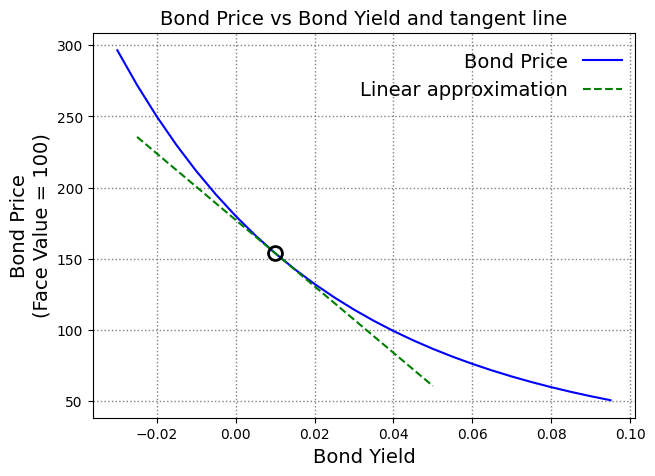

In [8]:
import numpy as np

SELECTED_YIELD = 0.01  # draw line tangent to the curve at this yield value


def plot_bond_duration_approximation():
    """
    Plot a single bond price vs yield curve,
    and a tangent line showing the linear approximation at the point of tangency
    """
    
    # --- settings ---
    bond_yields = np.arange(-0.03, 0.10, 0.005)  # yield values for which the price should be calculated
    tangent_yield_min_max = [-0.025, 0.05]  # yield end points of the tangent line
    fontsize = 14  # font size for the text of the current plot
    coupon_percent = 4.0
    symbol = 'b-'
    tangent_line_symbol = 'g--'

    # --- calculating the price as a function of the yield ---
    bond_prices = []
    for bond_yield in bond_yields:
        coupon_payment_frequency = COUPON_PAYMENT_FREQUENCY
        zero_rates = [bond_yield] * int(BOND_DURATION_IN_YEARS * coupon_payment_frequency)
        pv = bond_pricer(yearly_coupon_percent=coupon_percent, zero_rates=zero_rates,
                         coupon_payment_frequency=coupon_payment_frequency, use='pv')
        bond_prices.append(pv)

    zero_rates = [SELECTED_YIELD] * int(BOND_DURATION_IN_YEARS * coupon_payment_frequency)
    price_at_selected_yield = bond_pricer(yearly_coupon_percent=coupon_percent, zero_rates=zero_rates,
                                          coupon_payment_frequency=COUPON_PAYMENT_FREQUENCY, use='pv')
    slope = bond_pricer(yearly_coupon_percent=coupon_percent, zero_rates=zero_rates,
                        coupon_payment_frequency=COUPON_PAYMENT_FREQUENCY, use='slope')
    tangent_price_end_points = [price_at_selected_yield + slope * (bond_yield - SELECTED_YIELD)
                                for bond_yield in tangent_yield_min_max]
    
    # --- plotting ---
    plt.grid(color='gray', linestyle=':', linewidth=1)
    plt.plot(bond_yields, bond_prices, symbol, markersize=PLOT_MARKERSIZE, label='Bond Price')
    plt.plot(tangent_yield_min_max, tangent_price_end_points, tangent_line_symbol,
             label='Linear approximation')
    plt.title('Bond Price vs Bond Yield and tangent line', fontsize=fontsize)
    plt.xlabel('Bond Yield', fontsize=fontsize)
    plt.ylabel('Bond Price\n(Face Value = 100)', fontsize=fontsize)
    plt.plot([SELECTED_YIELD], [price_at_selected_yield],
             color='black', marker='o', linewidth=0, markersize=10, fillstyle='none', markeredgewidth=2)
    plt.legend(bbox_to_anchor=(.99, .97), loc=1, borderaxespad=0., fontsize=fontsize, markerfirst=False, frameon=False)

    fig = plt.gcf()
    fig.set_size_inches([7, 5])
    plt.show()


plot_bond_duration_approximation()

##### Note

The bond price vs bond yield curve is convex.

In other words, the linear approximation underestimates the price.

# Calculate the ZC yield curve from market data

This is also called: bootstrapping the yield curve.

## Examples
### One-year bond

A one-year bond with 4% coupon paid semi-annually starts now and trades at 98. For 6m the `simple rate` is 5%.

**Question:** What is the 1y simple rate ?

**Help:** (a) Remember the conventions (default values). (b) Multiply rate with time length.

The current market value is the sum of the PVs of all future payments :

$$98=\frac{2}{1+\frac{1}{2}\cdot 0.05}+\frac{102}{1+L\left(1\right)}$$

Therefore, the 1y simple rate is 
$$
\color{red}{L\left(\,1\,\right)} 
\,\, = \,\, 
\frac{102}{\displaystyle{98-\frac{2}{1+\frac{1}{2}\cdot 0.05} } } \, - \, 1 
\,\,\,\, \color{red}{ \approx \,\, 6.20\%}
$$

In [9]:
pv = (102 / (98 - 2 / (1 + 0.5 * 0.05))) - 1
print(f'L(1)={100*pv:.2f}%')

L(1)=6.20%


##### How sensitive is the resulting 1y rate to the 6m rate ?

In the formula for the PV, the enumerator $\,2\,$ is roughly $\,50\,$ times smaller than the $\,98\,$ on the l.h.s, or the $\,102\,$ in the other enumerator.

The change of the rate $\,0.05\,$ is multiplied by $\,\frac{1}{2}\,$.

Taken together, a small $\,x\,$ relative change of the 6m rate will result in an approx. $\,x\,\mathit{/}\,100\,$ relative change of $\,L\left(1\right)\,$.

### Two-year bond

A two-year bond with 5% coupon starts now and currently trades at par. For 6m, 1y and 18m the `simple rate` is 2%, 3% and 4%. Calculate the 2y point of the yield curve.

The current market value is the sum of the PVs of all future payments :

$$100=\frac{2.5}{1+\frac{1}{2}\cdot 0.02}+\frac{2.5}{1+0.03}+\frac{2.5}{1+\frac{3}{2}\cdot 0.04}+\frac{102.5}{1+2\cdot L\left(2\right)}$$

Therefore, the 2y simple rate is :
$$\color{red}{L\left(\,2\,\right)} \,\, = \,\, \frac{1}{2}\,\cdot\,\left( \frac{102.5}{100-\left(\frac{2.5}{1\,+\,\frac{1}{2}\,\cdot\,0.02}+\frac{2.5}{1\,+\,0.03}+\frac{2.5}{1\,+\,\frac{3}{2}\,\cdot\,0.04}\right) } - 1 \right)
\,\,\,\, \color{red}{\approx\,\, 5.28\%}$$

In [10]:
pv = 0.5 * (102.5 / (100 - 2.5 * (1.0/1.01 + 1/1.015 + 1/1.06))- 1) 
print(f'L(2)={100*pv:.2f}%')

L(2)=5.28%


##### Which payment is the largest ?

The last payment -- when the notional is repaid -- is the largest.

Therefore, if the other yields (ZC rates) are not too far from the coupon rate,
<br/>
then the ZC rate for the time of maturity will also be close to the coupon rate.


## By parts: short, mid, long


Often, the yield curve is built using 3 types of products: short, medium and long tenor products,
<br/>
for example: <= 1y, 2y-10y, > 10y.
